In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os, pickle

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from msfm.utils import logger, files, scales, power_spectra, parameters, observation
from deep_lss.utils import configuration
from msi.utils import preprocessing

# v14

In [3]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended"

### combined

In [4]:
with_lensing = True
with_clustering = True
params = ["Om", "s8", "w0", "Aia", "n_Aia", "bta", "bg1", "bg2", "bg3", "bg4"]

file_label = "8,32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/combined/dlss_{file_label}.yaml"
)

# maps
# grateful-universe-1093 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/tun9hdvl/overview)
# first v14 combined probes run
model_dir = "/pscratch/sd/a/athomsen/run_files/v14/extended/combined/mutual_info/2025-04-30_02-27-42_deepsphere_default"
n_steps_maps = 400_000

25-06-27 05:55:09 configuratio INF   Loaded the config 


In [5]:
# dataset
fidu_preds, grid_preds, grid_cosmos, file_dict = preprocessing.get_reshaped_network_preds(
    "",
    model_dir,
    n_steps_maps,
)

buzzard_indices = list(range(0, 16))
buzzard_indices.remove(1)
buzzard_preds = []
for i in buzzard_indices:
    buzzard_preds.append(file_dict[f"mocks/pred/Buzzard_{i}"])
buzzard_preds = np.stack(buzzard_preds, axis=0)

# output directory and file names
out_dir = os.path.join(base_dir, model_dir)

label = f"{n_steps_maps}_steps_likelihood"

print(grid_preds.shape)
print(grid_cosmos.shape)
print(buzzard_preds.shape)

25-06-27 05:55:10 input_output INF   Loading predictions from /pscratch/sd/a/athomsen/run_files/v14/extended/combined/mutual_info/2025-04-30_02-27-42_deepsphere_default/preds_400000.h5 
25-06-27 05:55:10 input_output INF   Array shapes: 
25-06-27 05:55:10 input_output INF   fiducial/vali/pred = (40000, 20) 
25-06-27 05:55:10 input_output INF   fiducial/vali/i_example = (40000,) 
25-06-27 05:55:10 input_output INF   fiducial/vali/i_noise = (40000,) 
25-06-27 05:55:10 input_output INF   grid/pred          = (2500, 80, 20) 
25-06-27 05:55:10 input_output INF   grid/cosmo         = (2500, 80, 10) 
25-06-27 05:55:10 input_output INF   grid/i_example     = (2500, 80) 
25-06-27 05:55:10 input_output INF   grid/i_noise       = (2500, 80) 
25-06-27 05:55:10 input_output INF   grid/i_sobol       = (2500, 80) 


25-06-27 05:55:10 preprocessin INF   Shapes after concatenation and selection: 
25-06-27 05:55:10 preprocessin INF   fidu_preds  = (40000, 20) 
25-06-27 05:55:10 preprocessin INF   grid_p

In [6]:
grid_preds.shape

(200000, 20)

[0.01277908 0.03585386 0.00502243 0.00702751 0.00521896 0.00223838
 0.00350362 0.0109968  0.00789613 0.01251413 0.0073075  0.00999263
 0.01450325 0.00675221 0.00232655 0.00298478 0.0237044  0.04968699
 0.08909971 0.01764619]
Buzzard_6


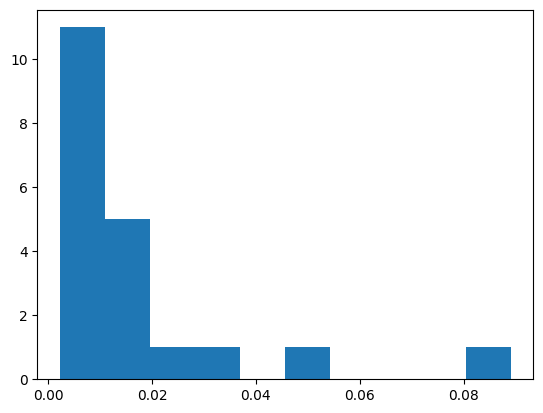

In [19]:
scaler = StandardScaler().fit(grid_preds)

buzzard_preds_standard = scaler.transform(buzzard_preds) 
diff = buzzard_preds_standard - np.mean(buzzard_preds_standard, axis=0)
mse = np.mean(diff**2, axis=0)
print(mse)
plt.hist(mse)

I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
best_buzzard = f"Buzzard_{I[np.argmin(mse)]}"
print(best_buzzard)

[0.19444984 0.18377672 0.11653323 0.07779513 0.07961807 0.04051679
 0.05612331 0.13780884 0.07081997 0.08049209 0.0829072  0.23498832
 0.12417267 0.0816664  0.08528398 0.05801697 0.15811597 0.15349285
 0.17543413 0.10089124]
Buzzard_6


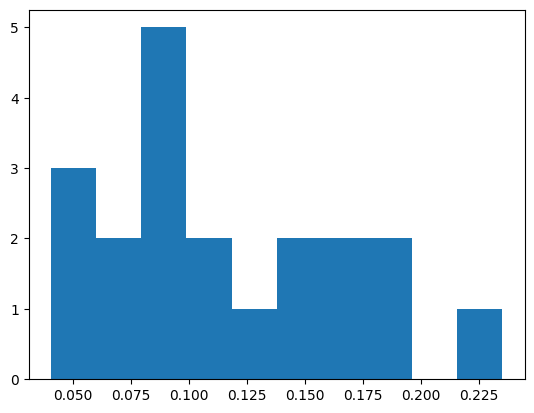

In [20]:
diff = buzzard_preds - np.mean(buzzard_preds, axis=0)
mse = np.mean(diff**2, axis=0)
print(mse)
plt.hist(mse)

# for the labels
I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
best_buzzard = f"Buzzard_{I[np.argmin(mse)]}"
print(best_buzzard)

In [14]:
mse

array([0.19444984, 0.18377672, 0.11653323, 0.07779513, 0.07961807,
       0.04051679, 0.05612331, 0.13780884, 0.07081997, 0.08049209,
       0.0829072 , 0.23498832, 0.12417267, 0.0816664 , 0.08528398,
       0.05801697, 0.15811597, 0.15349285, 0.17543413, 0.10089124],
      dtype=float32)

In [11]:
best_buzzard

'Buzzard_6'

In [13]:
params = ["Om", "s8", "w0", "Aia", "n_Aia", "bta", "bg1", "bg2", "bg3", "bg4"]
l_maxs = [589, 863, 1159, 1382] + [133, 195, 255, 305]
n_z = 8

label = "8,32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/combined/dlss_{label}.yaml"
)

25-06-26 02:39:33 configuratio INF   Loaded the config 


### load buzzards

In [14]:
def get_obs_cls(lensing_file, clustering_file, nest_in=False):
    # load the mock
    with h5py.File(lensing_file, "r") as f_in:
        gamma1 = []
        gamma2 = []
        for j in range(1,5):
            gamma1.append(f_in[f"metacal/raw_gamma1_bin{j}"])
            gamma2.append(f_in[f"metacal/raw_gamma2_bin{j}"])
        gamma1 = np.stack(gamma1, axis=-1)
        gamma2 = np.stack(gamma2, axis=-1)
        
        wl_map = np.stack([gamma1, gamma2], axis=-1)

    with h5py.File(clustering_file, "r") as f_in:
        gc_map = []
        for i in range(1,5):
            gc_map.append(f_in[f"maglim/galaxy_counts_bin{i}"][:])
        gc_map = np.stack(gc_map, axis=-1)

    # forward model
    obs_cls = preprocessing.get_preprocessed_cl_observation(
        wl_gamma_map=wl_map,
        gc_count_map=gc_map,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        nest_in=False,
        make_plot=False,
        # selection
        with_lensing=True,
        with_clustering=True,
        with_cross_z=True,
        with_cross_probe=True,
        # additional preprocessing
        apply_log=False,
        standardize=False,
    )

    return np.squeeze(obs_cls)

In [26]:
obs_cls = []

I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
K = ["a"] + 7 * ["a", "b"]
# for i, j, k in tqdm(list(zip(I, J, K))[:2]):
for i, j, k in tqdm(zip(I, J, K)):
    lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
    clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
    obs_cls.append(get_obs_cls(lensing_file, clustering_file))

obs_cls = np.stack(obs_cls, axis=0)
obs_cls_mean = np.mean(obs_cls, axis=0)

0it [00:00, ?it/s]

25-06-26 02:42:54 configuratio INF   Loaded the config 
25-06-26 02:42:54 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:42:54 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:43:11 preprocessin INF   Adding white noise to the observation 
25-06-26 02:43:11 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


1it [00:17, 17.15s/it]

25-06-26 02:43:11 configuratio INF   Loaded the config 
25-06-26 02:43:11 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:43:11 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:43:31 preprocessin INF   Adding white noise to the observation 
25-06-26 02:43:31 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


2it [00:36, 18.52s/it]

25-06-26 02:43:32 configuratio INF   Loaded the config 
25-06-26 02:43:32 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:43:32 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:43:51 preprocessin INF   Adding white noise to the observation 
25-06-26 02:43:51 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


3it [00:57, 19.55s/it]

25-06-26 02:43:52 configuratio INF   Loaded the config 
25-06-26 02:43:52 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:43:52 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:44:09 preprocessin INF   Adding white noise to the observation 
25-06-26 02:44:09 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


4it [01:15, 18.81s/it]

25-06-26 02:44:10 configuratio INF   Loaded the config 
25-06-26 02:44:10 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:44:10 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:44:27 preprocessin INF   Adding white noise to the observation 
25-06-26 02:44:27 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


5it [01:33, 18.55s/it]

25-06-26 02:44:28 configuratio INF   Loaded the config 
25-06-26 02:44:28 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:44:28 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:44:45 preprocessin INF   Adding white noise to the observation 
25-06-26 02:44:45 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


6it [01:50, 18.28s/it]

25-06-26 02:44:45 configuratio INF   Loaded the config 
25-06-26 02:44:45 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:44:45 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:45:02 preprocessin INF   Adding white noise to the observation 
25-06-26 02:45:02 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


7it [02:08, 17.98s/it]

25-06-26 02:45:03 configuratio INF   Loaded the config 
25-06-26 02:45:03 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:45:03 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:45:19 preprocessin INF   Adding white noise to the observation 
25-06-26 02:45:19 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


8it [02:25, 17.73s/it]

25-06-26 02:45:20 configuratio INF   Loaded the config 
25-06-26 02:45:20 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:45:20 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:45:38 preprocessin INF   Adding white noise to the observation 
25-06-26 02:45:38 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


9it [02:43, 17.90s/it]

25-06-26 02:45:38 configuratio INF   Loaded the config 
25-06-26 02:45:38 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:45:38 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:45:55 preprocessin INF   Adding white noise to the observation 
25-06-26 02:45:55 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


10it [03:01, 17.77s/it]

25-06-26 02:45:56 configuratio INF   Loaded the config 
25-06-26 02:45:56 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:45:56 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:46:14 preprocessin INF   Adding white noise to the observation 
25-06-26 02:46:14 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


11it [03:19, 18.00s/it]

25-06-26 02:46:14 configuratio INF   Loaded the config 
25-06-26 02:46:14 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:46:14 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:46:32 preprocessin INF   Adding white noise to the observation 
25-06-26 02:46:32 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


12it [03:37, 17.98s/it]

25-06-26 02:46:32 configuratio INF   Loaded the config 
25-06-26 02:46:32 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:46:32 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:46:49 preprocessin INF   Adding white noise to the observation 
25-06-26 02:46:49 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


13it [03:55, 17.82s/it]

25-06-26 02:46:50 configuratio INF   Loaded the config 
25-06-26 02:46:50 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:46:50 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:47:09 preprocessin INF   Adding white noise to the observation 
25-06-26 02:47:09 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


14it [04:15, 18.50s/it]

25-06-26 02:47:10 configuratio INF   Loaded the config 
25-06-26 02:47:10 preprocessin INF   Using l_maxs = [366.10169492 537.31343284 720.         857.14285714  82.94930876
 121.4848144  158.59030837 189.47368421] from the dlss config 
25-06-26 02:47:10 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-26 02:47:28 preprocessin INF   Adding white noise to the observation 
25-06-26 02:47:28 preprocessin INF   Using the bin indices [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35] 


15it [04:34, 18.28s/it]


In [27]:
diff = obs_cls - obs_cls_mean
mse = np.mean(diff**2, axis=1)

(array([3., 3., 0., 2., 2., 0., 2., 2., 0., 1.]),
 array([2.66596715e-12, 4.62134072e-12, 6.57671430e-12, 8.53208787e-12,
        1.04874614e-11, 1.24428350e-11, 1.43982086e-11, 1.63535822e-11,
        1.83089557e-11, 2.02643293e-11, 2.22197029e-11]),
 <BarContainer object of 10 artists>)

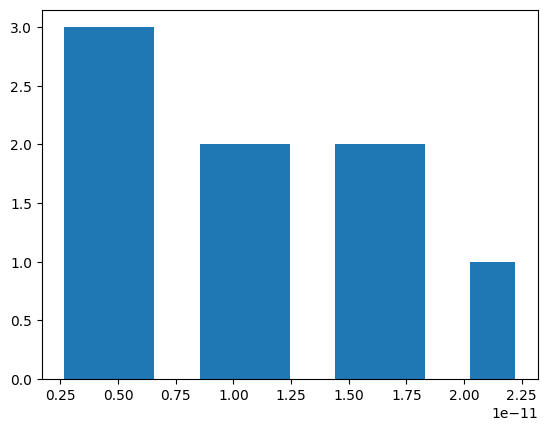

In [28]:
plt.hist(mse)

In [29]:
np.argmin(mse)

7

In [31]:
np.min(mse)

2.6659671455863248e-12

In [30]:
mse

array([1.17868790e-11, 2.22197029e-11, 1.52479258e-11, 6.49354971e-12,
       9.19064282e-12, 1.76584645e-11, 1.62112947e-11, 2.66596715e-12,
       1.75176495e-11, 8.78161418e-12, 1.15037307e-11, 3.55858617e-12,
       4.85230039e-12, 4.44807532e-12, 5.05581630e-12])

In [32]:
I[np.argmin(mse)]

8

[None]

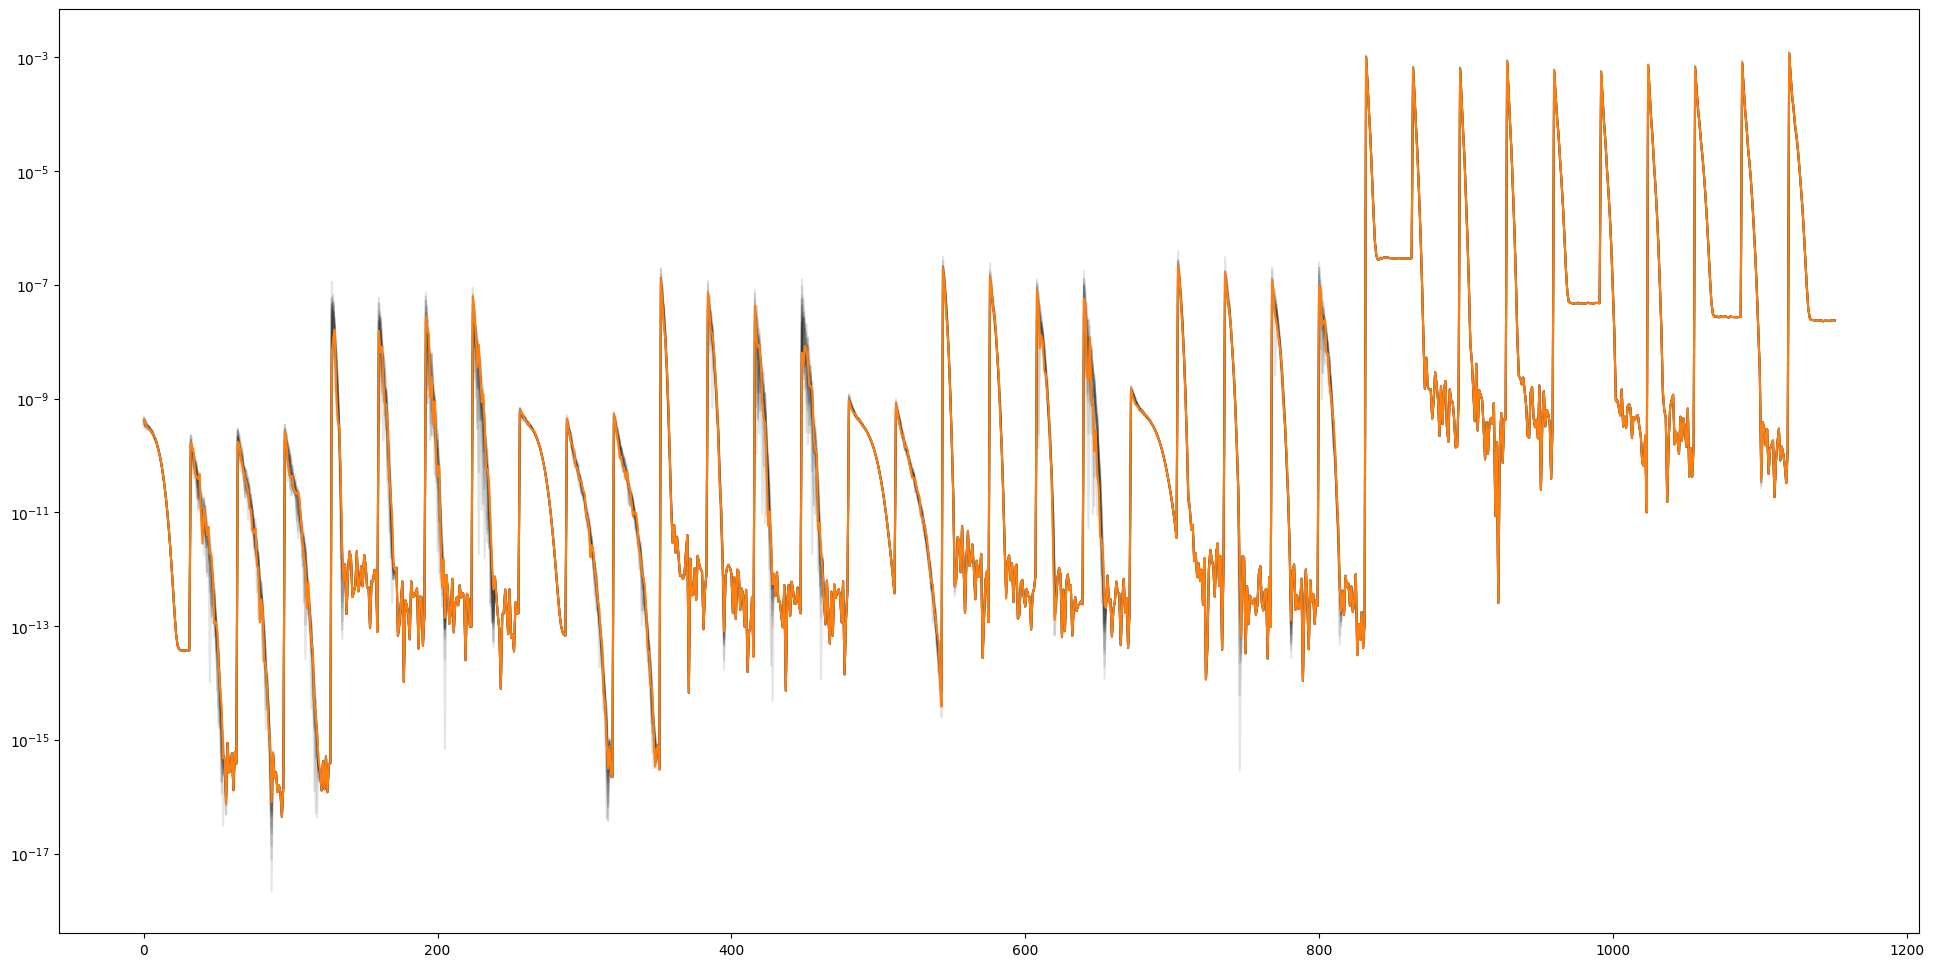

In [39]:
fig, ax = plt.subplots(figsize=(24,12))

ax.plot(np.abs(obs_cls).T, color="k", alpha=0.1)
ax.plot(np.abs(obs_cls[np.argmin(mse)]), color="tab:orange")
ax.set(yscale="log")